## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='images/lookup_matrix.png' width=40%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='images/tokenize_lookup.png' width=30%>

---
## Word2Vec

A particular type of model called Word2Vec uses the embedding layer to find vector representations of words that contain semantic meaning. The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="images/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="images/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="images/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

## Loading Data
Loading the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 

In [1]:
# read in the extracted text file      
with open('data/TextData/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Preprocessing

In [2]:
from collections import Counter

def preprocess(text):
    '''
    Pre-process the text to make it suitable for training
    
    '''
    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    remaining_words = [word for word in words if word_counts[word] > 5]

    return remaining_words


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab and vocab_to_int dictionaries
    int_to_vocab = {i: word for i, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: i for i, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [3]:
words = preprocess(text)

# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words in text: 16680599
Unique words: 63641


In [4]:
# words are sorted from most to least frequent in text occurrence
vocab_to_int, int_to_vocab = create_lookup_tables(words)
# convert words in text to their integer id
int_words = [vocab_to_int[word] for word in words]

# see the first 10 most frequent words
print(list(int_to_vocab.items())[:10])
print()
# see the first 20 words in text and their integer id
print(list(zip(int_words[:40], words[:40])))

[(0, 'the'), (1, 'of'), (2, 'and'), (3, 'one'), (4, 'in'), (5, 'a'), (6, 'to'), (7, 'zero'), (8, 'nine'), (9, 'two')]

[(5233, 'anarchism'), (3080, 'originated'), (11, 'as'), (5, 'a'), (194, 'term'), (1, 'of'), (3133, 'abuse'), (45, 'first'), (58, 'used'), (155, 'against'), (127, 'early'), (741, 'working'), (476, 'class'), (10571, 'radicals'), (133, 'including'), (0, 'the'), (27349, 'diggers'), (1, 'of'), (0, 'the'), (102, 'english'), (854, 'revolution'), (2, 'and'), (0, 'the'), (15067, 'sans'), (58112, 'culottes'), (1, 'of'), (0, 'the'), (150, 'french'), (854, 'revolution'), (3580, 'whilst'), (0, 'the'), (194, 'term'), (10, 'is'), (190, 'still'), (58, 'used'), (4, 'in'), (5, 'a'), (10712, 'pejorative'), (214, 'way'), (6, 'to')]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset. For example, for the word "the" which has integer id = 0,

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

Note that the total number of words $\approx16\times10^{6}$ and the number of occurances of the word "the" $\approx1\times10^{6}$

In [5]:
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

# free the memory allocated for freqs
del freqs

# discard some words according to p_drop, generate a new list of words for training
train_int_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [6]:
# see the first 20 words for training. note that some words are dropped
# according to the subsampling policy
print([(i, int_to_vocab[i]) for i in train_int_words[:20]])

[(5233, 'anarchism'), (10571, 'radicals'), (27349, 'diggers'), (15067, 'sans'), (58112, 'culottes'), (10712, 'pejorative'), (214, 'way'), (1324, 'describe'), (454, 'act'), (6, 'to'), (3672, 'destroy'), (2757, 'label'), (686, 'defined'), (7088, 'anarchists'), (5233, 'anarchism'), (44611, 'archons'), (2877, 'ruler'), (5233, 'anarchism'), (8983, 'unnecessary'), (6437, 'differing')]


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."


Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [7]:
def get_target(words, idx, window_size=5):
    ''' 
    receives a list of words, an index, and a window size,
    returns a list of words in the window around the index. 
    '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches, for each word x within each batch, return
        (x, list of words in the window around x) 
    '''
    
    # only full batches
    words = words[:(len(words)//batch_size) * batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_target(batch, i, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [8]:
int_list = [i for i in range(20)]

for i,(x,y) in enumerate(get_batches(int_list, batch_size=5, window_size=4)):
    print("batch {}:".format(i))
    print("x\n", x)
    print("y\n", y)

batch 0:
x
 [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4]
y
 [1, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 1, 2, 3]
batch 1:
x
 [5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9]
y
 [6, 5, 7, 5, 6, 8, 9, 5, 6, 7, 9, 8]
batch 2:
x
 [10, 10, 11, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14]
y
 [11, 12, 10, 12, 13, 10, 11, 13, 14, 12, 14, 10, 11, 12, 13]
batch 3:
x
 [15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19]
y
 [16, 17, 15, 17, 18, 15, 16, 18, 19, 15, 16, 17, 19, 18]


## Skip-gram Architecture

Below is an approximate diagram of the general structure of **our particular network**.
<img src="images/skip_gram_arch.png" width=60%>

* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

Then, for example, for prediction with an input of one word, we expect to see the following (the following structure is different from the structure we implemented, but the idea is the same):

<img src="images/skip_gram_arch_one_hot.png" width=70%>


---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [9]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. For a random word vector a and the embedding vector b,
    # sim = (a . b) / |a||b|

    embed_mat = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_mat.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies higher frequency 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_mat.t())/magnitudes

    return valid_examples, similarities

## SkipGram Pytorch

An nn.Embedding takes in a number of inputs, most importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [10]:
import torch
from torch import nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(num_embeddings=n_vocab, embedding_dim=n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_prob = self.log_softmax(scores)
        
        return log_prob

### Training

In [11]:
from tqdm import tqdm

# set to only use %80 of GPU memory
torch.cuda.set_per_process_memory_fraction(0.8, 0)
torch.cuda.empty_cache()

# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim = 300

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1000
steps = 0
epochs = 5
batch_size = 512

# train for some number of epochs
for e in range(epochs):
    # get input and target batches
    for _, (inputs, targets) in tqdm(enumerate(get_batches(train_int_words, batch_size)),
                                     desc="Training epoch {}".format(e+1),
                                     total=len(train_int_words)//batch_size,
                                     leave=True):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        log_prob = model(inputs)
        loss = criterion(log_prob, targets)
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

Training epoch 1:  11%|██████▊                                                      | 1005/9035 [00:37<04:58, 26.94it/s]

war | terminally, imitators, complicate, but, transcendence
this | nationalisation, squared, suppressed, lemmon, brueys
th | shorty, writings, huangdi, ner, competitor
new | lecture, dysphoria, hew, ailment, landsbergis
states | birthrate, belladonna, multiplications, mikhail, kadena
are | encompassed, ayrton, estrangement, easy, repos
only | tithe, pinsent, encroachment, daisuke, standstill
he | bradley, agitators, coordinator, cns, woodpeckers
pope | karst, drew, comedians, professional, boas
placed | subnet, rightful, midwifery, anatomy, upscale
quite | grams, tortuous, crows, frederick, aligned
notes | figurative, nm, iwo, degraded, circumvent
consists | rectus, camelidae, exploitable, inadequately, aleichem
grand | pastiches, affordable, workgroup, bellevue, criticizes
units | glaser, anniversary, puck, lodge, pawson
centre | decapitation, moreau, directing, disposal, congruent
...


Training epoch 1:  22%|█████████████▌                                               | 2004/9035 [01:14<04:55, 23.78it/s]

known | claudian, ridley, strau, fills, datasheet
with | statism, raising, comprehension, ferries, gigantopithecus
would | anacharsis, stark, profession, affleck, nelson
but | harlan, muscovy, excluded, war, placidia
use | androgeus, yell, convene, griggs, imaginings
in | stared, wray, catacombs, varangian, nothingness
state | adviser, banded, tte, amicably, salient
about | finkel, when, dances, nazarbayev, hod
numerous | caster, bentine, vagrant, handover, hotter
file | compatibility, wholeheartedly, outing, bushy, cheka
troops | blossomed, esk, feng, swiftness, priscillian
magazine | gioacchino, eu, reisman, discovering, orally
heavy | cma, electorally, bade, irl, hyperinflation
liberal | battlecruisers, katrina, tireless, kotaka, fluorides
nobel | tankage, bedouins, stitched, poets, bayqongyr
universe | fib, fukuyama, hammerstein, shuffles, rehnquist
...


Training epoch 1:  33%|████████████████████▎                                        | 3004/9035 [01:54<03:46, 26.68it/s]

b | chipped, stews, armies, rampart, genet
and | london, goose, cityscape, ravine, shaper
have | husserl, eckernf, citing, long, jacobian
the | applicable, adverse, plankton, tramiel, acceptance
its | resolver, fashion, injustice, letterpress, affaires
will | malts, strive, marsupial, calcutta, fiduciary
a | stevens, above, foresight, bdg, for
so | trait, virgil, wagstaff, pioneers, characterization
professional | ubiquitous, enables, cosimo, krupp, alves
accepted | verden, rnir, ags, artifice, lounges
operations | richmond, nervous, aquaria, cheka, craven
prince | paddling, observationally, sends, stifled, bearing
report | diffracting, qur, madison, knowable, lewin
engine | vlsi, video, galleries, konservatorium, adhesion
lived | mencius, inked, cho, entranced, palace
grand | pastiches, workgroup, tupolev, bellevue, unenforceable
...


Training epoch 1:  44%|███████████████████████████                                  | 4004/9035 [02:33<03:10, 26.36it/s]

th | shorty, huangdi, writings, reforestation, flourished
many | brochure, raymond, vacations, ergot, schizophrenia
s | lingerie, gustave, accessed, gupta, pilgrimages
time | mythography, phosphorylated, curds, awadhi, modulator
more | nath, miho, fsm, subproblems, paraphernalia
three | chorales, trice, five, radiate, cuthbert
such | lineups, number, courante, gtpases, heroic
states | birthrate, menhirs, narn, tuscan, tajikistan
pressure | pediatrics, grown, compounds, haganah, intriguing
account | federated, papert, eliminates, body, biodiesel
bible | honestly, kotzebue, texts, steered, evolved
running | joysticks, enso, scrolling, nonpartisan, expedited
magazine | gioacchino, customizations, eu, discovering, igor
construction | heaviside, submarine, merging, taya, kremvax
http | sociological, castlevania, formulate, brzezinski, harmonic
police | whose, boone, reintroduce, men, transpose
...


Training epoch 1:  55%|█████████████████████████████████▊                           | 5006/9035 [03:12<02:31, 26.56it/s]

from | retreats, visas, vorkosigan, tripod, neoptolemus
has | aerospace, downtempo, affiliation, fergusson, desolate
however | vaillant, werth, whealey, contorted, suborder
some | relevant, sade, exact, angela, aspirated
d | faial, sfr, copernicus, manet, kelly
with | statism, ferries, remains, gigantopithecus, submergence
all | ayy, repugnant, ma, ets, chd
seven | uman, diplomatique, marine, nine, bdf
scale | each, krone, lilac, steppe, varying
discovered | mus, irrealism, science, kind, unvoiced
paris | akrotiri, arno, ce, fairclough, braudel
troops | blossomed, feng, niels, esk, nwaf
taking | scant, modifying, ziegler, alley, mos
consists | rectus, camelidae, perlite, inadequately, ippolito
resources | darby, ninotchka, francis, walruses, fulham
operating | exponentiation, compatibles, ejecting, gua, sedimentary
...


Training epoch 1:  66%|████████████████████████████████████████▌                    | 6004/9035 [03:51<01:50, 27.42it/s]

most | precedence, euphoria, rsten, wavre, hsv
system | maine, managers, vhdl, frag, robie
of | tib, podiums, curiae, the, barrichello
which | intransitive, crucially, also, barfield, prophecy
after | shortly, chesterton, umm, chairperson, marathons
s | gupta, shocked, lingerie, gustave, posing
as | underbrace, raspberry, bolshevik, hanno, mpt
more | nath, miho, subproblems, fsm, ema
taking | scant, modifying, mos, obstinately, alley
hold | trumped, little, oppressors, obliged, miners
nobel | poets, bedouins, chemistry, pertinax, interviewed
brother | jespersen, passer, turboprop, porphyry, lulu
mean | constellations, confined, maldivians, echoes, happening
engine | vlsi, galleries, adhesion, konservatorium, video
arts | ticker, stanshall, lakers, signification, historique
running | joysticks, scrolling, enso, newburgh, expedited
...


Training epoch 1:  78%|███████████████████████████████████████████████▎             | 7003/9035 [04:30<01:19, 25.40it/s]

d | one, b, manet, kelly, pierre
his | wore, bebox, anjou, savage, protestors
there | branes, holt, agnosticism, gunship, ealing
and | petrus, crowley, tenor, london, five
new | lecture, nationally, blackwell, dysphoria, burundian
often | operettas, storch, morel, lsap, napa
up | eratis, halt, policyholders, questions, morehouse
a | the, stevens, sentiments, mismatched, for
taking | scant, obstinately, mos, santer, alley
quite | grams, crows, ren, athletes, mutually
experience | pensions, polydor, horton, protecting, critiqued
pressure | pediatrics, compounds, amway, air, townships
rise | lexicon, gn, coffins, frontage, legates
defense | segregation, dvi, tillman, flavian, marseillaise
bible | honestly, texts, machpelah, steered, demigods
versions | cpt, overshadowing, fools, devolution, teri
...


Training epoch 1:  89%|██████████████████████████████████████████████████████       | 8005/9035 [05:09<00:42, 24.15it/s]

use | pipelining, indica, machines, midsize, object
years | two, devastation, nine, multiplied, sperm
s | calabrian, disambiguation, booch, gustave, tro
seven | two, nine, five, eight, one
six | five, two, nine, four, one
from | vorkosigan, phytoplankton, snowfall, gelre, neoptolemus
has | bingen, enzymatic, compromise, assesses, desolate
one | zero, five, four, three, two
issue | ngos, avondale, andropov, referendum, pepin
dr | bhakti, shea, borderlands, asserted, crichton
square | savarkar, nelly, unloading, hyperlinked, legnica
construction | heaviside, submarine, taya, tempel, merging
operating | compatibles, sourceforge, kfreebsd, gua, integrated
mathematics | tyramine, logic, lok, metaphysics, algebras
san | kanons, roshan, enlists, lapses, bedside
magazine | gioacchino, customizations, discovering, reisman, syn
...


Training epoch 1: 100%|████████████████████████████████████████████████████████████▊| 9003/9035 [05:49<00:01, 25.74it/s]

known | ridley, agitated, appears, fertiliser, name
years | multiplied, two, sperm, months, devastation
all | purport, repugnant, flak, leda, uh
an | explains, puts, brattle, foci, skel
often | operettas, morel, strings, napa, funny
state | ircii, banded, lindsey, secretary, conquests
th | shorty, nd, crimean, empire, flourished
after | shortly, when, umm, capella, cobain
running | joysticks, scrolling, nonpartisan, enso, remembered
rise | gn, lexicon, legates, coffins, oil
freedom | acquisition, arrogance, apokryphen, matre, linji
numerous | pliny, handover, boingo, sussman, bucket
prince | lh, stifled, paddling, uf, arkady
scale | approximating, nieve, steppe, battery, varying
resources | darby, facility, cashier, computer, database
construction | merging, heaviside, submarine, stuart, taya
...


Training epoch 2:  11%|██████▋                                                       | 969/9035 [00:37<05:12, 25.78it/s]

at | building, erant, piscis, firepower, southampton
they | reticent, had, stimulate, osvaldo, backgrounds
or | formatting, scientifically, elective, angelique, used
during | propulsion, mounting, landing, fortress, army
zero | one, two, five, three, four
of | in, duke, kama, emperor, machpelah
used | joukahainen, accumulates, use, glyphs, jervis
b | d, eight, diplomat, zoologist, six
bill | manager, lawson, nigel, jon, interim
applications | stack, locke, kernels, characterizes, scanner
liberal | mcelroy, party, congestion, kotaka, revolutionary
defense | segregation, interception, attack, dvi, equipping
ice | subsequence, montage, plateaus, seasons, sain
articles | online, herzog, preprocessor, gyrus, homiletical
engine | vlsi, konservatorium, propulsion, galleries, tms
pressure | upwards, pediatrics, polymer, pounders, paycheck
...


Training epoch 2:  22%|█████████████▎                                               | 1970/9035 [01:19<04:58, 23.68it/s]

often | have, strings, ons, such, unexplained
when | after, yearwood, treated, again, ambitions
his | he, wore, after, anjou, adoptive
one | zero, three, two, four, six
can | breath, function, uncountable, vouli, maximums
while | superheroes, seperated, sqq, honorary, pigpen
states | tajikistan, attorney, tors, menhirs, birthrate
in | the, first, invitations, last, of
behind | ferrigno, carefully, rampant, discogs, sturmgewehr
accepted | people, jamnia, ags, inadequacy, soteriology
cost | zoltan, profits, kg, lodged, ajahn
derived | glottis, corresponding, esd, banna, cracking
http | www, archive, htm, org, html
mathematics | logic, tyramine, philanthropic, metaphysics, prodigies
hold | trumped, obliged, putting, verily, pseudepigraphical
stage | rasa, longtime, cockroach, nim, waltz
...


Training epoch 2:  33%|████████████████████                                         | 2969/9035 [01:58<03:53, 26.00it/s]

state | secretary, district, adviser, angie, salient
which | is, the, making, also, that
it | not, so, persecutions, can, paraffin
up | halt, tracks, flipping, sidelined, breathe
people | haskalah, lives, syndrome, hostility, abdallah
to | not, accept, allow, they, zealous
be | not, a, is, phrased, inputs
been | apprehension, consequent, capable, overly, struggled
applications | scanner, locke, stack, kernels, systems
notes | nm, esquerra, elegy, associativity, circumvent
issue | ngos, referendum, intend, retaining, constitutes
creation | escola, vision, monophysitism, remarque, rashid
report | knowable, lewin, diffracting, news, thoth
construction | campus, merging, insecticides, ysyk, powered
brother | jespersen, britney, passer, mausoleum, adour
numerous | handover, caster, pliny, vagrant, initiate
...


Training epoch 2:  44%|██████████████████████████▊                                  | 3970/9035 [02:38<03:38, 23.18it/s]

over | zero, a, two, five, grub
which | is, also, that, the, in
than | more, humourous, pint, octonions, distributism
at | high, miles, s, nearby, traveling
war | troops, trusteeship, wwi, soldiers, gni
i | know, you, your, me, we
an | commit, ember, equations, unwittingly, to
history | tanzanian, links, of, lynyrd, textual
defense | insolvency, interception, nuclear, force, vannevar
quite | grams, ren, fossil, amicable, overlapping
account | saavedra, reigns, federated, kief, bonner
applications | locke, kernels, stack, scanner, characterizes
institute | mit, oxford, neural, comarca, mater
bbc | day, airing, weekly, banned, cuar
primarily | hushed, displays, integration, practise, wide
proposed | descend, aye, pentane, freemason, dump
...


Training epoch 2:  55%|█████████████████████████████████▌                           | 4970/9035 [03:21<02:48, 24.15it/s]

such | explanations, often, generally, currying, various
six | five, one, two, eight, three
some | many, it, to, potable, dressage
or | is, are, elective, used, smirnov
will | you, allows, exchanged, be, predict
th | nd, rd, eight, century, brocklin
of | the, in, on, a, is
more | than, constrained, conceptual, nath, contrast
notes | nm, universal, elegy, associativity, conducting
award | awards, medal, awarded, winners, veteran
versions | overshadowing, orthographies, typesetting, cpt, available
applications | scanner, locke, kernels, stack, domains
orthodox | catholic, constituency, thrace, theodoric, islam
issue | ngos, referendum, retaining, andropov, constitutes
nobel | prize, chemist, chemistry, physiology, physicist
professional | firearms, presper, woodbridge, ume, performances
...


Training epoch 2:  66%|████████████████████████████████████████▎                    | 5969/9035 [04:06<01:49, 28.03it/s]

all | for, the, and, are, is
an | of, the, by, maintained, as
known | name, ridley, woodlands, catalyze, ulaanbaatar
of | the, in, a, from, and
i | you, ferdinand, know, we, me
it | not, is, some, that, can
in | the, of, were, a, from
up | rest, halt, sidelined, policyholders, defeats
construction | rail, building, facilities, nameservers, skyscraper
notes | elegy, piano, deconstructing, nm, holiness
report | review, news, reports, knowable, ttt
units | unit, transformed, blissymbolics, battalion, darwinists
professional | firearms, users, presper, ncaa, performances
assembly | assembl, elections, constitution, parliament, members
taking | scant, obstinately, shivering, sweet, vertov
joseph | wissenschaften, colin, crowell, isaac, elaborations
...


Training epoch 2:  77%|███████████████████████████████████████████████              | 6967/9035 [04:46<01:25, 24.31it/s]

two | three, zero, four, five, one
american | nine, three, actor, one, b
on | the, of, at, s, two
or | commonly, is, used, elective, other
states | united, attorney, canada, u, state
often | such, have, are, or, combination
other | have, umbrella, diverse, various, are
state | states, district, pluriform, secretary, lindsey
experience | subconscious, pensions, leisure, paraphrasing, sighted
articles | online, herzog, magazine, history, gettier
orthodox | catholic, converts, thrace, clergy, theodoric
behind | rampant, carefully, fastball, followings, figuratively
paris | french, de, mer, france, du
magazine | magazines, published, books, weekly, daffy
writers | births, poets, novelists, fiction, actors
grand | pastiches, suspends, buckingham, theodoric, stanton
...


Training epoch 2:  88%|█████████████████████████████████████████████████████▊       | 7970/9035 [05:28<00:54, 19.38it/s]

where | delta, e, then, praying, i
other | have, are, some, such, umbrella
his | he, died, him, brother, she
see | article, links, disambiguation, list, external
while | seperated, poking, antitank, albeit, opensource
only | but, the, to, any, much
system | systems, interface, operating, which, multi
all | individual, pennant, consecutive, absolute, minamoto
stage | rasa, musical, excavating, nim, longtime
frac | x, sqrt, constant, approximation, circ
arts | art, academy, museum, sports, techniques
question | questions, cried, nothing, objections, critique
mainly | and, limited, migrants, eastern, pearls
applications | systems, kernels, module, stack, tasks
cost | drawback, flowery, pricing, wco, sell
joseph | elaborations, wissenschaften, laughlin, isaac, ancien
...


Training epoch 2:  99%|████████████████████████████████████████████████████████████▌| 8968/9035 [06:09<00:02, 25.15it/s]

between | closely, draws, ends, culturally, widens
which | the, is, a, of, called
on | a, the, at, moving, front
no | credentials, duklja, none, locating, caucasian
war | troops, army, during, forces, soviet
a | the, is, in, as, on
often | such, various, have, especially, sometimes
it | not, to, would, is, while
shown | thymine, formalisms, exit, inflected, histones
except | vasoconstriction, executables, innodb, sophomores, or
bill | manager, bittorrent, nigel, bius, bills
mathematics | mathematical, theory, prodigies, logic, contributions
operations | operation, u, army, strategic, counter
animals | humans, animal, glutamic, mammals, survive
something | thing, premise, you, things, what
behind | front, discogs, booms, fastball, squeezes
...


Training epoch 3:  10%|██████▍                                                       | 934/9035 [00:41<05:12, 25.91it/s]

may | requires, hypoxia, april, mean, camouflaged
i | you, say, my, know, me
these | are, many, differentiation, their, proteins
world | germany, war, cgi, nations, wco
three | one, five, four, two, seven
and | of, the, in, on, s
years | age, year, months, older, population
its | the, launched, early, expansion, debugger
marriage | married, wife, child, mother, divorce
pre | colonialism, longship, existed, europeans, earley
recorded | album, release, discography, last, drukqs
scale | varying, approximating, pitches, redshift, dispersion
hit | run, hits, explosions, fencers, quarter
discovered | whitehaven, discovery, chemist, nahi, uranus
mean | calculated, constellations, may, n, leprosy
egypt | egyptian, bc, parthians, sinai, conquered
...


Training epoch 3:  21%|█████████████                                                | 1932/9035 [01:28<05:27, 21.71it/s]

to | allow, would, this, required, their
three | five, one, two, four, seven
known | the, in, early, tisha, prehistoric
american | musician, actor, nine, singer, african
this | a, the, given, to, that
with | and, while, of, on, the
five | three, four, six, two, zero
by | the, of, was, as, from
something | thing, you, so, what, pinscher
ice | vinegar, plateaus, around, snow, montage
engine | engines, mxy, piston, wheel, cc
operations | operation, strategic, sappers, u, army
construction | building, facilities, rail, mall, skyscraper
older | age, years, size, median, family
resources | arable, database, curriculum, crops, bordering
writers | births, actors, novelists, poets, deaths
...


Training epoch 3:  32%|███████████████████▊                                         | 2934/9035 [02:08<03:58, 25.53it/s]

the | and, in, a, second, from
where | q, delta, then, other, sometimes
war | troops, during, army, warfare, soviet
during | war, period, after, october, until
all | and, for, are, every, of
this | given, the, then, a, that
will | you, must, need, perseverance, int
to | would, they, their, not, them
gold | silver, nickel, precious, coins, mineral
smith | joseph, economics, businessman, burnett, jesus
discovered | chemist, discovery, whitehaven, observed, found
placed | shaped, trombone, barracuda, alluvial, karts
cost | payments, prices, explosive, price, low
existence | that, universe, belief, reality, asserts
behind | fastball, spot, capped, dorset, play
lived | farm, kwakiutl, liar, friends, invaded
...


Training epoch 3:  44%|██████████████████████████▌                                  | 3936/9035 [02:49<03:11, 26.62it/s]

when | then, heated, that, after, finally
he | his, him, she, had, himself
to | that, they, however, their, attempt
system | systems, operating, interface, installed, multi
war | troops, casualties, warfare, soviet, army
by | of, the, as, from, and
the | and, of, on, a, in
people | births, deaths, living, actors, americans
joseph | d, smith, bethune, laureate, james
centre | area, shopping, estrella, stadiums, sweepers
versions | version, available, windows, original, compatible
mainly | migrants, peasants, many, today, increased
orthodox | catholic, churches, clergy, liturgy, eastern
liberal | conservative, conservatives, devolution, party, parliamentary
heavy | myr, steel, jamming, heaviest, transference
quite | even, certain, enamels, perhaps, mutually
...


Training epoch 3:  55%|█████████████████████████████████▎                           | 4934/9035 [03:28<02:35, 26.40it/s]

and | the, of, with, a, for
these | many, are, some, have, more
five | six, three, four, two, zero
would | that, but, to, them, it
two | one, three, four, zero, five
from | by, the, of, in, that
had | he, was, were, later, his
the | on, of, a, is, and
derived | greek, suffix, word, name, meaning
troops | war, army, armies, soldiers, battalion
test | tests, ban, maximise, wickets, ozone
assembly | elections, parliament, assembl, elected, amendment
liberal | conservative, conservatives, political, party, democrats
construction | building, built, soaring, yb, rail
universe | galaxy, existence, our, worlds, cosmological
ice | snow, rideau, frozen, plateaus, straightened
...


Training epoch 3:  66%|████████████████████████████████████████                     | 5934/9035 [04:07<02:07, 24.37it/s]

had | was, were, later, he, been
time | period, months, hours, when, during
state | government, states, federal, kingdom, autonomy
so | not, them, what, that, to
more | than, less, much, these, even
its | the, has, in, of, further
zero | one, two, five, four, three
he | his, him, she, himself, was
instance | are, intrusive, diphthongs, undercroft, committing
event | events, celebrations, leap, evenly, festival
derived | suffix, root, word, name, cognates
defense | defence, branches, civilian, department, insolvency
construction | built, building, plaza, rail, skyscraper
square | xz, coordinates, height, rectangular, sides
mainly | peasants, migrants, local, eastern, today
shown | used, vowels, thymine, silent, swahili
...


Training epoch 3:  77%|██████████████████████████████████████████████▊              | 6934/9035 [04:47<01:26, 24.36it/s]

see | article, list, external, links, of
to | the, their, in, them, an
all | rule, to, them, grammarians, they
may | the, or, are, december, is
be | have, can, actually, not, could
s | nine, of, eight, the, six
are | have, generally, often, consist, these
were | been, millions, most, few, had
primarily | variety, disadvantaged, dominates, forms, wide
rise | regime, sects, rapidly, invocations, central
additional | required, technical, allows, replication, facilitate
derived | word, compound, used, suffix, hebrew
lived | farm, settled, warlike, grandfather, maternal
operations | operation, special, ordered, strategic, operators
san | francisco, antonio, jose, juan, beach
dr | doctor, rama, commissioner, engstrom, holbrook
...


Training epoch 3:  88%|█████████████████████████████████████████████████████▌       | 7935/9035 [05:28<00:45, 24.33it/s]

had | he, later, was, were, after
for | a, using, is, use, used
time | hours, months, half, period, pm
has | the, have, is, been, are
more | less, than, are, many, easily
he | his, him, had, was, she
between | ends, with, separated, determination, stretching
years | year, months, age, five, infant
hold | believe, held, must, interlocking, decisions
nobel | prize, laureate, physicist, physiology, chemist
bible | testament, scripture, biblical, talmud, translations
professional | hockey, association, trained, baseball, ncaa
versions | version, windows, available, original, modified
creation | evolution, demiurge, disallowing, webpage, roulette
defense | defence, branches, offense, department, civilian
pre | longship, ledger, existed, old, medieval
...


Training epoch 3:  99%|████████████████████████████████████████████████████████████▎| 8934/9035 [06:08<00:04, 24.65it/s]

no | cannot, only, is, any, present
four | three, five, one, two, six
s | nine, eight, six, the, zero
history | links, site, external, michael, of
they | their, them, were, would, do
called | the, is, as, this, a
many | other, some, most, have, few
state | states, district, united, counties, legislature
woman | children, her, she, birth, male
assembly | elected, elections, parliament, government, legislative
egypt | egyptian, cairo, arab, egyptians, mesopotamia
liberal | conservative, conservatives, educated, democrats, evangelical
discovered | discovery, found, chemist, discoveries, richter
primarily | heavily, as, developed, dominates, largely
resources | environment, arable, resource, database, licencing
older | age, household, median, size, years
...


Training epoch 4:  10%|██████▏                                                       | 899/9035 [00:35<05:01, 26.99it/s]

there | are, remaining, several, most, generally
or | is, such, used, commonly, of
after | later, shortly, days, first, november
no | cannot, only, udv, allegiance, not
his | he, wife, him, brother, son
who | whom, people, him, others, person
known | of, in, and, references, by
so | would, come, nrsv, that, should
rise | rapidly, decline, regime, ensuing, central
recorded | album, discography, songs, song, record
consists | consisting, serves, include, legislative, main
event | events, celebrations, ironwood, host, olympic
behind | fastball, spot, front, hit, hitting
report | review, reports, investigation, pdf, journal
magazine | magazines, weekly, published, editorial, editor
police | officers, arrested, fbi, convicted, officer
...


Training epoch 4:  21%|████████████▊                                                | 1897/9035 [01:14<04:32, 26.23it/s]

people | living, persons, americans, entertainers, who
see | list, links, external, article, meanings
can | if, be, are, need, might
in | the, of, and, after, was
for | all, while, as, only, with
an | a, called, is, double, the
over | three, two, four, zero, years
was | later, by, in, after, during
road | roads, highway, suburbs, railroad, bridge
resources | arable, resource, environment, curriculum, database
bbc | monday, february, listing, radio, broadcast
issue | editorial, decolonisation, journalistic, hawke, editors
centre | harbour, shopping, located, manchester, around
account | accounts, book, story, josephus, historical
professional | association, amateur, hockey, baseball, ncaa
report | reports, investigation, news, review, peer
...


Training epoch 4:  32%|███████████████████▌                                         | 2899/9035 [01:53<03:58, 25.77it/s]

states | united, america, state, u, vietnam
four | one, two, three, five, six
its | the, which, in, of, city
and | the, of, in, with, other
between | divided, within, separated, third, ends
than | less, are, more, half, higher
eight | one, six, nine, four, zero
which | is, by, also, form, its
defense | opponents, defence, offense, drafted, coach
marriage | married, divorce, wife, her, marry
writers | novelists, births, fiction, natives, poets
award | awards, best, won, awarded, winners
taking | gaugamela, cyclically, take, completing, pvp
report | reports, investigation, review, commission, cia
bbc | tv, monday, radio, on, february
troops | war, forces, soldiers, army, artillery
...


Training epoch 4:  43%|██████████████████████████▎                                  | 3899/9035 [02:35<03:08, 27.24it/s]

state | states, federal, city, violated, interstate
eight | one, seven, nine, five, four
some | are, various, or, different, many
s | nine, the, and, one, a
nine | one, eight, seven, six, five
between | behavior, within, point, same, these
during | period, occurred, following, after, until
new | york, ny, states, canada, company
brother | her, elder, son, cousin, he
active | oxygen, enzymes, volcano, cortona, carbonaceous
experience | experiences, impairment, awareness, abilities, insight
stage | theater, actors, hollywood, jester, renouf
know | we, t, think, you, do
arts | art, martial, academy, education, sciences
pope | papal, xii, pius, papacy, gregory
orthodox | churches, orthodoxy, patriarch, catholic, muslims
...


Training epoch 4:  54%|█████████████████████████████████                            | 4899/9035 [03:22<02:56, 23.43it/s]

from | the, in, of, by, period
has | its, have, the, in, been
three | two, six, one, four, five
over | years, two, the, zero, under
to | the, be, but, will, they
all | not, are, this, number, for
however | was, alone, but, to, have
only | are, the, not, any, remaining
woman | her, female, husband, noun, birth
operating | windows, systems, unix, os, dos
engineering | engineers, technology, opencourseware, sciences, management
event | events, sporting, year, marking, staged
smith | joseph, maynard, robert, american, d
additional | required, employ, omitted, modulation, hennecke
notes | timothy, tone, links, scales, zondervan
pressure | temperature, liquid, temperatures, energy, boiling
...


Training epoch 4:  65%|███████████████████████████████████████▊                     | 5898/9035 [04:01<02:08, 24.43it/s]

history | origins, ancient, links, following, modern
had | was, were, later, he, changed
he | his, him, himself, was, she
at | one, died, five, the, s
five | four, six, zero, three, two
in | the, of, a, and, was
also | and, for, see, other, of
nine | seven, one, eight, three, four
ocean | atlantic, pacific, islands, stations, satellite
marriage | marry, divorce, married, daughter, her
institute | university, research, universities, engineering, sciences
active | passive, volcano, connected, strong, enlist
accepted | recognized, accept, canon, bishops, accepts
arts | art, martial, museum, sciences, museums
rise | harsh, toward, decline, influx, scandinavia
issue | issues, resolved, magazine, opinion, controversial
...


Training epoch 4:  76%|██████████████████████████████████████████████▌              | 6901/9035 [04:40<01:21, 26.04it/s]

up | out, fled, back, shot, the
was | he, had, the, his, in
seven | eight, one, six, five, four
one | eight, six, five, seven, nine
over | years, under, total, off, reaching
that | it, be, not, as, have
so | do, we, you, i, can
of | the, and, in, one, eight
orthodox | orthodoxy, churches, church, liturgy, byzantine
placed | inserted, usually, urn, protects, kept
engine | engines, piston, combustion, diesel, compressed
articles | dictionary, online, library, article, news
road | roads, expressway, bridge, highway, rail
alternative | major, today, affiliate, goldberg, pics
except | only, there, any, all, possession
account | accounts, transactions, book, kips, gentis
...


Training epoch 4:  87%|█████████████████████████████████████████████████████▎       | 7900/9035 [05:23<00:46, 24.64it/s]

time | the, hours, first, months, entire
it | that, is, a, true, not
been | were, recent, decades, suspected, have
would | they, decided, so, to, shocked
the | in, of, which, is, and
over | zero, two, five, total, three
two | four, three, five, nine, one
be | can, if, is, not, that
governor | governors, appointed, president, senator, executive
operations | operation, operators, base, special, sappers
construction | built, building, infrastructure, completed, constructed
bill | bills, manager, senator, willie, tucker
liberal | conservative, conservatives, conservatism, political, social
primarily | dominates, popular, based, many, developed
mean | doesn, calculated, f, if, definition
joseph | smith, moses, bethune, william, louis
...


Training epoch 4:  99%|████████████████████████████████████████████████████████████ | 8900/9035 [06:07<00:05, 24.90it/s]

about | average, there, information, why, wiki
history | of, origins, site, website, in
from | the, to, until, at, is
during | began, period, war, severe, after
in | the, s, a, of, and
time | months, second, twice, seconds, utc
their | they, were, while, move, the
of | and, the, one, in, five
bbc | february, day, monday, march, news
know | think, want, you, don, do
freedom | liberty, rights, freedoms, recipients, moral
report | news, reports, investigation, peer, journal
assembly | elected, parliament, deputies, elections, legislative
ocean | pacific, satellite, islands, atlantic, volcanic
egypt | egyptian, cairo, egyptians, bc, nile
nobel | prize, laureate, physicist, chemist, recipient
...


Training epoch 5:  10%|█████▉                                                        | 865/9035 [00:33<05:04, 26.86it/s]

who | whom, him, parents, he, mother
seven | one, four, three, five, two
other | include, some, are, many, similar
during | war, after, began, period, siege
from | the, to, and, old, into
zero | two, five, one, eight, six
eight | one, three, four, six, seven
to | the, would, with, were, and
engine | engines, powered, diesel, piston, combustion
troops | army, battle, war, forces, soldiers
police | officers, fbi, convicted, enforcement, arrested
issue | issues, resolved, dispute, neves, controversial
experience | experiences, feeling, awareness, moral, abilities
numerous | throughout, several, among, important, mounds
mainly | middle, today, many, mostly, rise
construction | building, dam, built, skyscraper, pottery
...


Training epoch 5:  21%|████████████▌                                                | 1863/9035 [01:15<06:21, 18.82it/s]

only | all, not, for, have, while
d | b, laureate, politician, c, ois
after | later, in, before, first, was
one | four, two, three, eight, six
of | the, and, in, by, is
up | out, take, to, in, with
about | average, there, baden, estimated, articles
is | the, as, which, in, a
mean | calculated, value, inequality, arithmetic, root
cost | costs, price, dollars, productivity, prices
accepted | rejected, recognized, accept, differing, cuvier
http | www, htm, com, html, edu
active | passive, promote, direct, mckinnon, cooperation
additional | plus, components, derivatives, inventory, primary
arts | art, martial, museums, sciences, museum
file | files, software, format, metadata, formats
...


Training epoch 5:  32%|███████████████████▎                                         | 2864/9035 [01:58<03:46, 27.25it/s]

an | a, is, the, in, or
zero | one, two, four, five, three
from | the, is, in, and, derived
these | are, they, some, various, and
the | in, and, of, is, a
had | he, was, were, turned, afterwards
or | a, usually, are, is, used
and | of, the, in, with, other
heavy | armored, infantry, armour, heavily, heaviest
san | francisco, diego, jose, juan, antonio
assembly | elected, elections, deputies, unicameral, legislative
additional | plus, funds, provided, are, these
magazine | magazines, published, monthly, journal, weekly
instance | types, basic, or, using, can
troops | army, forces, soldiers, war, deployed
road | roads, highway, bridge, expressway, streets
...


Training epoch 5:  43%|██████████████████████████                                   | 3863/9035 [02:39<03:22, 25.48it/s]

has | its, recent, is, have, been
history | links, topics, external, references, bibliography
however | that, not, but, does, be
an | a, the, or, is, uses
called | the, a, shown, is, usually
that | be, not, have, of, however
they | would, their, them, themselves, do
to | they, do, attempt, their, would
stage | theater, grammy, actors, musical, picture
file | files, documentation, software, format, unix
freedom | freedoms, liberty, democracy, ethical, individualism
centre | situated, centres, area, nightlife, danelaw
cost | price, costs, prices, payments, consumer
account | accounts, historians, described, description, testimony
creation | evolution, creationism, biblical, creative, existence
hit | hits, singles, hank, scored, throwing
...


Training epoch 5:  54%|████████████████████████████████▊                            | 4865/9035 [03:20<02:44, 25.29it/s]

war | fought, army, troops, allied, civil
where | left, delta, when, then, home
is | a, are, the, in, if
years | year, age, twenty, months, days
may | or, not, is, are, associated
called | an, is, of, call, by
an | a, called, is, the, in
people | americans, ethnic, foreigners, living, persons
existence | theories, belief, reality, universe, possible
magazine | magazines, published, monthly, weekly, newspaper
arts | art, museums, sciences, education, academy
applications | application, computers, methods, systems, voltage
know | you, i, doesn, t, how
troops | army, battle, soldiers, siege, war
joseph | smith, d, john, b, antoine
scale | scales, harmonic, macroscopic, larger, richter
...


Training epoch 5:  65%|███████████████████████████████████████▌                     | 5864/9035 [04:01<02:11, 24.15it/s]

some | these, are, be, such, have
six | five, four, one, eight, three
its | the, has, in, action, expansion
it | is, that, a, be, the
history | origins, links, nine, topics, ancient
i | my, you, want, me, am
has | for, its, the, been, both
will | if, can, so, need, cannot
bible | tanakh, testament, biblical, torah, jesus
smith | maynard, joseph, larry, ed, oliver
recorded | recording, released, dates, lp, compilation
ocean | pacific, atlantic, stations, sea, satellite
quite | somewhat, perhaps, not, fewer, exaggeration
heavy | damage, sped, metal, relatively, artillery
bbc | news, february, monday, tv, itv
paris | du, france, french, sur, nantes
...


Training epoch 5:  76%|██████████████████████████████████████████████▎              | 6864/9035 [04:40<01:23, 26.01it/s]

over | years, zero, total, off, four
by | of, the, eight, one, and
their | they, them, respective, obliged, have
between | in, relationship, border, ends, are
history | links, origins, topics, of, university
or | normally, include, are, some, is
not | that, are, only, it, but
and | of, the, in, eight, one
channel | channels, broadcasting, network, cable, fm
older | age, median, females, household, younger
road | roads, expressway, highway, railway, bridge
ice | glacial, glaciers, cream, glacier, colder
taking | patriotism, recur, napoleon, completely, mortally
existence | exists, argument, view, belief, beings
hold | accept, dealt, they, unbroken, must
mathematics | mathematical, geometry, astronomy, euclid, calculus
...


Training epoch 5:  87%|█████████████████████████████████████████████████████        | 7863/9035 [05:20<00:49, 23.58it/s]

years | age, year, five, months, four
which | the, as, a, of, it
only | any, all, lower, are, not
to | the, a, they, because, be
first | second, the, in, after, a
after | he, before, later, had, returned
other | some, are, and, various, many
from | the, and, in, for, located
placed | wooden, pipe, inside, poured, piece
applications | application, desktop, using, windows, software
ocean | pacific, atlantic, islands, equator, volcanic
joseph | smith, william, moses, farrell, pierre
heavy | metal, soft, destroyer, lowering, trucks
proposed | proposal, executive, commission, consultative, approved
creation | demiurge, forever, evolution, eternal, promote
rise | during, regime, decline, factor, anti
...


Training epoch 5:  98%|███████████████████████████████████████████████████████████▊ | 8865/9035 [05:59<00:06, 25.77it/s]

states | united, state, president, u, kingdom
people | thousands, living, persons, residents, ethnic
other | some, many, various, including, include
years | months, year, age, over, twenty
on | the, with, to, for, section
who | whom, his, father, him, christian
into | the, of, sub, segments, called
where | delta, left, e, is, frankfurt
articles | page, wikipedia, online, dictionary, library
rise | decline, during, europe, seventeenth, movements
nobel | prize, laureate, physicist, chemist, recipient
grand | prix, frederick, duke, title, carlo
magazine | magazines, monthly, published, interview, story
marriage | marry, marriages, divorce, relationship, married
heavy | destroyer, punk, metal, cruiser, rock
accepted | rejected, recognized, accepts, legal, regarded
...


Training epoch 5: 100%|█████████████████████████████████████████████████████████████| 9035/9035 [06:05<00:00, 24.71it/s]


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/home/louisfanhz/miniconda3/envs/udacity/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/louisfanhz/miniconda3/envs/udacity/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


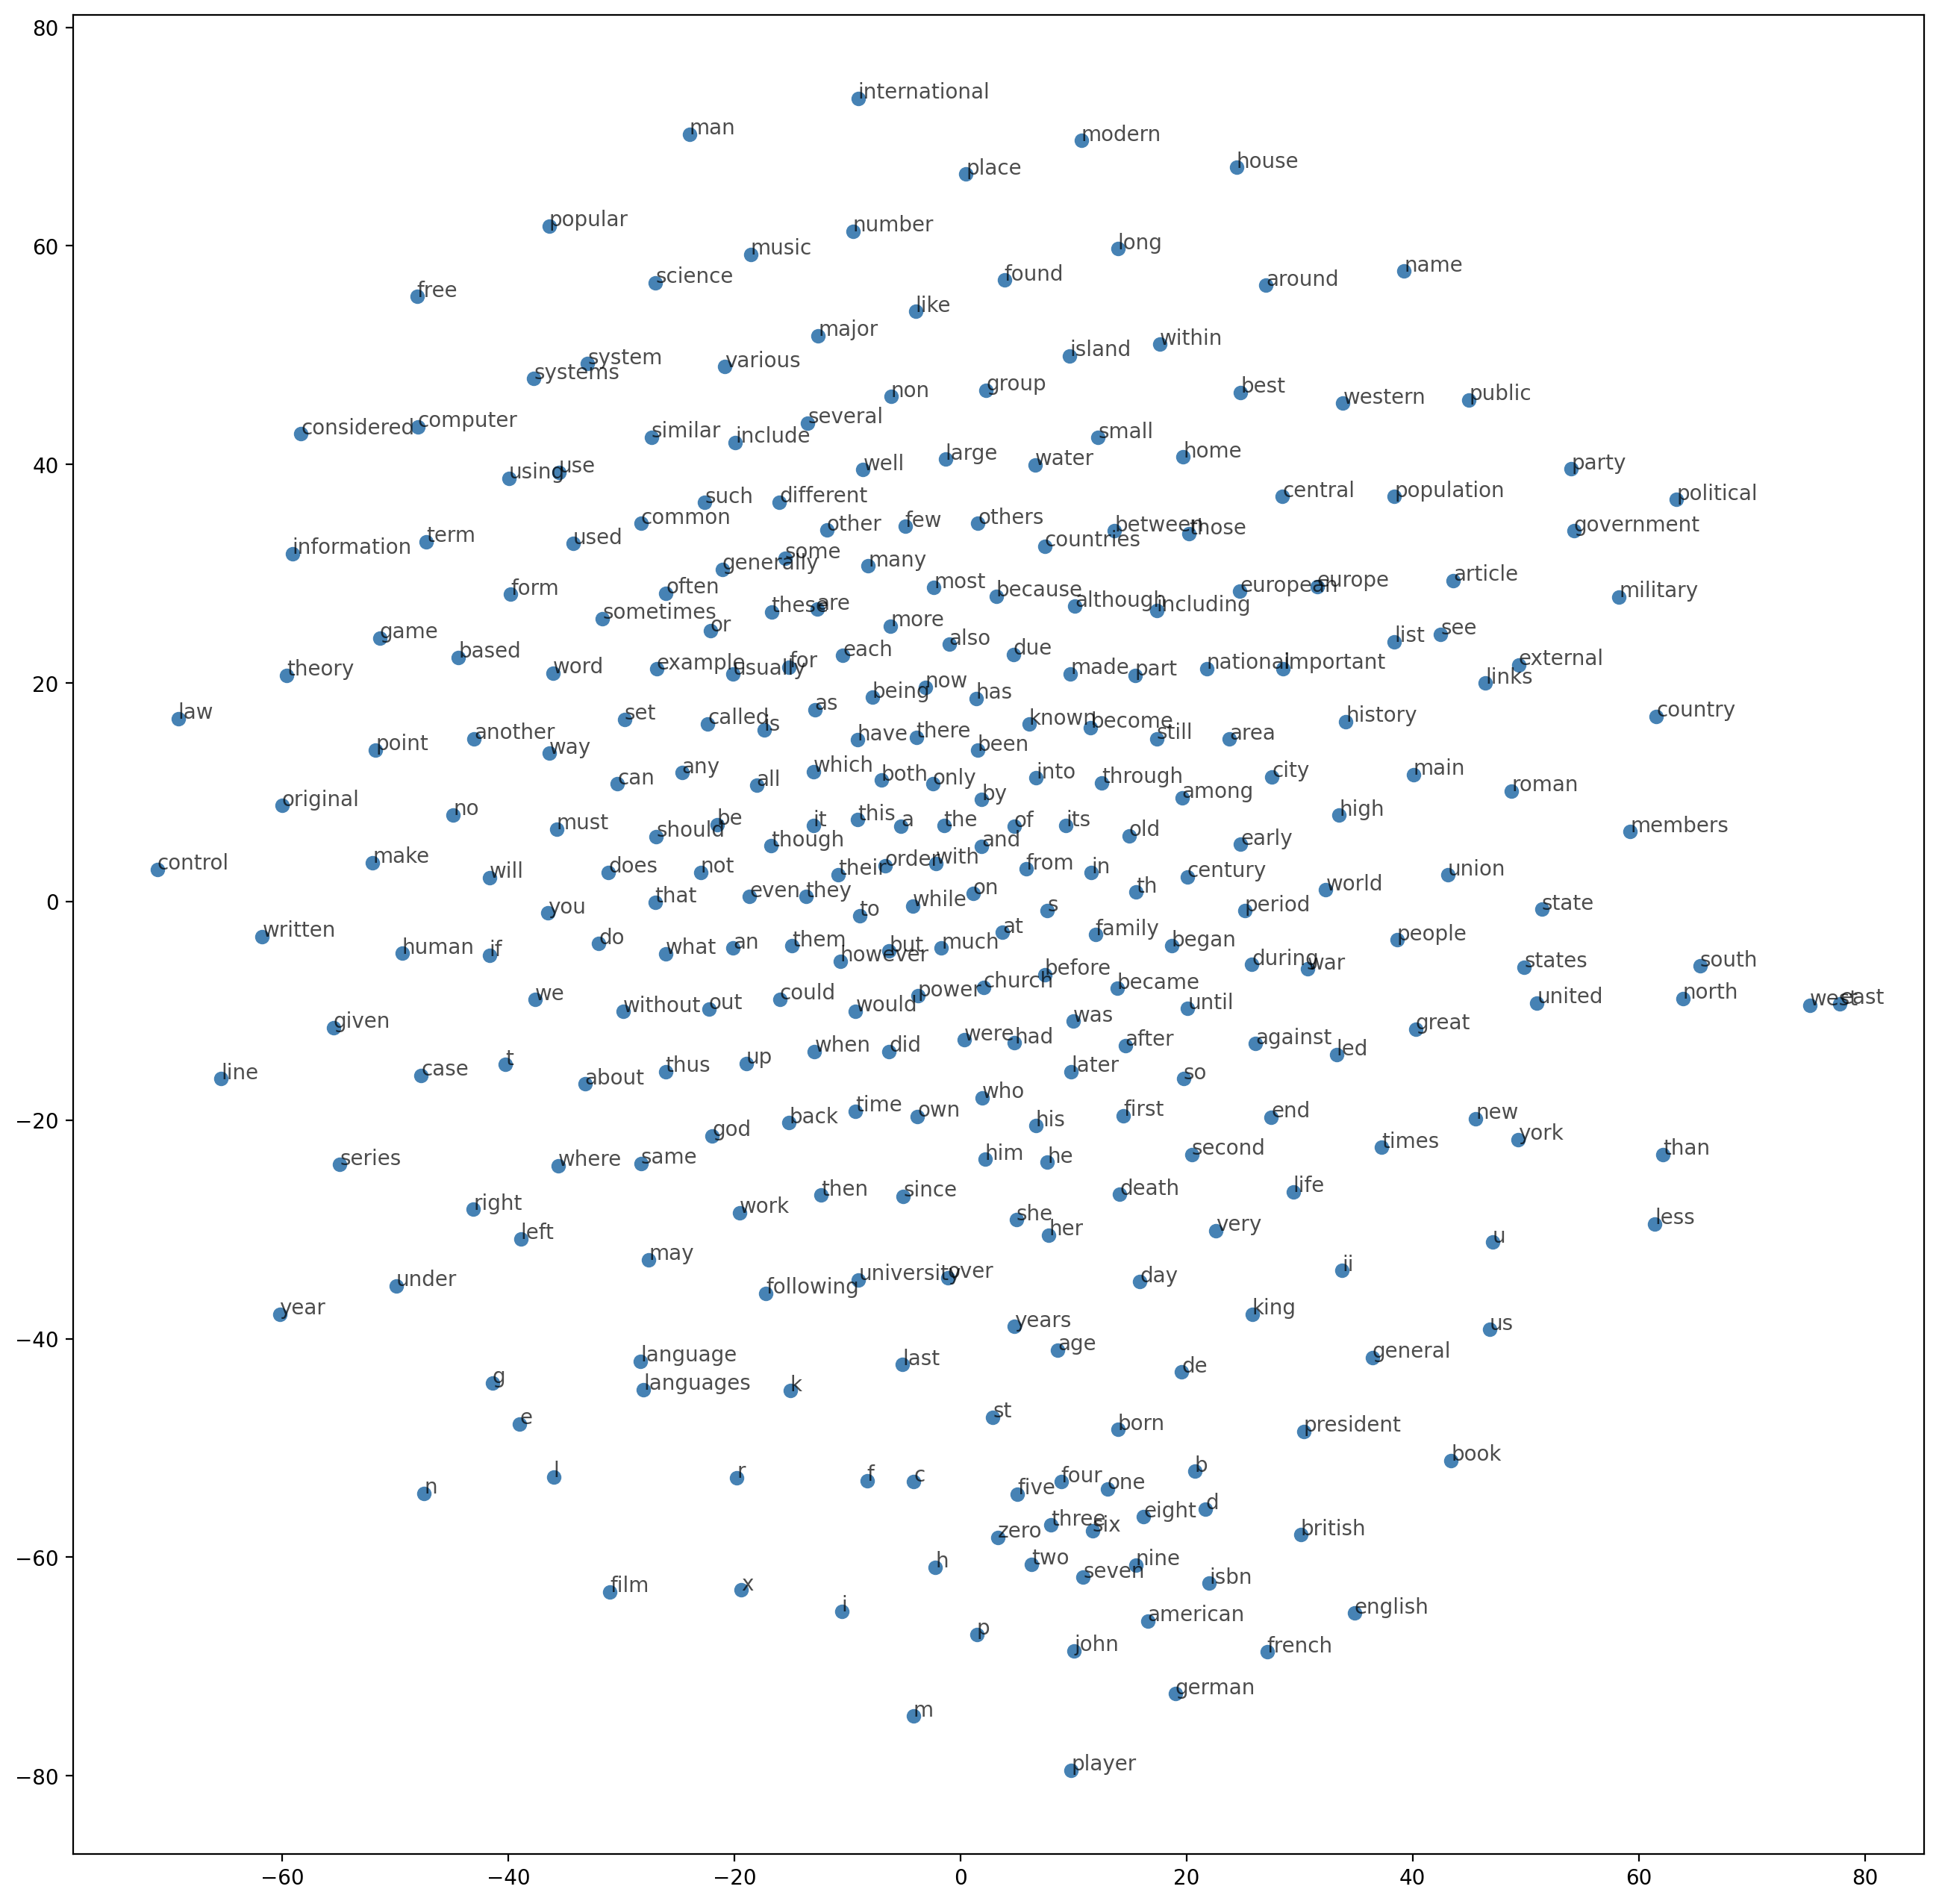

In [13]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)